**Data mining Project - University of Pisa, acedemic year 2023/24**
 
**Authors**: Giacomo Aru, Giulia Ghisolfi, Luca Marini, Irene Testa

# Clustering comparison

In this notebook, we compare the clustering results of the different methods. Since DBSCAN and Heirarchical clustering were applied only to the incidents happened in Illinois, we restrict the comparison to the incidents in this state. We remind that the state of Illinois was chosen because it had few null values and the distribution of the variables was similar to the distribution of the variables of the whole dataset.

We import the libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from clustering_utils import *
import sys, os
sys.path.append(os.path.abspath('..'))
from plot_utils import sankey_plot

We define the paths to the saved clustering results:

In [2]:
PATH = '../data/clustering_labels/'
clustering_name = ['KMeans', 'KMeansPCA', 'DBSCAN', 'Hierarchical']
labels_files = [PATH+'/4-Means_clusters.csv', PATH+'4-Means_PCA_clusters.csv', PATH+'DBSCAN_clusters.csv', PATH+'hierarchical_clusters.csv']
external_scores_files = [PATH+'4-Means_external_scores.csv', PATH+'4-Means_PCA_external_scores.csv', PATH+'DBSCAN_external_scores.csv', PATH+'hierarchical_external_scores.csv']
internal_scores_files = [PATH+'4-Means_internal_scores.csv', PATH+'4-Means_PCA_internal_scores.csv', PATH+'DBSCAN_internal_scores.csv', PATH+'hierarchical_internal_scores.csv']

We concatenate the clustering results into a single dataframe:

In [3]:
nrows = pd.read_csv(labels_files[0], index_col=0).shape[0]
clusters_df = pd.DataFrame(index=[i for i in range(nrows)])
for name, labels_file, external_score_file, internal_score_file in zip(clustering_name, labels_files, external_scores_files, internal_scores_files):
    clusters_curr_df = pd.read_csv(labels_file, index_col=0)
    clusters_curr_df = clusters_curr_df.rename(columns={'cluster':'cluster'+name})
    clusters_df = clusters_df.join(clusters_curr_df)
clusters_df.dropna(inplace=True)

We visualize the clustering results using a sankey diagram:

In [4]:
sankey_plot(
    [clusters_df['clusterDBSCAN'], clusters_df['clusterKMeans'], clusters_df['clusterKMeansPCA'], clusters_df['clusterHierarchical']],
    labels_titles=['DBSCAN', 'KMeans', 'KMeansPCA', 'Heirarchical'],
    title='Clusterings comparison'
)

The clusters found by KMeans applied to the indicators and the clusters found by KMeansPCA applied to the first principal components of the indicators are very similar. Cluster 2 of DBSCAN groups almost all the points from cluster 0, 1 and 3 of KMeans; while cluster 1 of DBSCAN groups almost all the points from cluster 2 of KMeans. Cluster 2 of KMeansPCA groups points belonging mainly to cluster 1, 2 and 6 of the Heirachical clustering. There is an high overlap between cluster 0 and 3 of KMeansPCA and Heirarchical clustering. Cluster 1 of KMeansPCA graoups all the points in cluster 5 of Heirarchical clustering. 

From this analysis, we can conclude that despite the differences in the methods, the clusters found are not so different.

Now we compare the internal scores of KMeans and KMenasPCA:

In [5]:
internal_scores_df = pd.DataFrame()
for name, internal_scores_file in zip(clustering_name[:2], internal_scores_files[:2]):
    internal_scores_curr_df = pd.read_csv(internal_scores_file, index_col=0).T
    internal_scores_df = pd.concat([internal_scores_df, internal_scores_curr_df])
internal_scores_df.rename(columns={'0':'silhouette_score'}, inplace=True)
internal_scores_df.drop(columns=['model'], inplace=True)
internal_scores_df

,BSS,SSE,calinski_harabasz_score,davies_bouldin_score,n_iter,silhouette_score
4means,57863.91870811196,51878.79845330116,49004.18671712359,1.2129926119852776,6,0.3268032005092862
4means PCA,19658.06936663372,18305.34787899599,47182.621915572796,1.203178019586672,5,0.3235205972416301


BSS and SSE are not comparable because the feature space on which we run the algorithms is different. The other scores are comparable. As for the Calinski-Harabasz score and the Silhouette score, the best results are obtained by KMeans, while for the Davies-Bouldin score the best results are obtained by KMeansPCA.

Now we compare the silhouette score of all the methods:

In [6]:
silhouette_df = internal_scores_df['silhouette_score'].to_frame()
DBSCAN_silhouette = pd.read_csv(PATH+'DBSCAN_internal_scores.csv', index_col=0)['silhouette_score'].values[0]
hierarchical_silhouette = pd.read_csv(PATH+'hierarchical_internal_scores.csv', index_col=0)['silhouette_score'].values[0]
pd.concat([silhouette_df, pd.DataFrame({'silhouette_score': [DBSCAN_silhouette, hierarchical_silhouette]}, index=['DBSCAN', 'Hierarchical'])])

,silhouette_score
4means,0.3268032005092862
4means PCA,0.3235205972416301
DBSCAN,0.251352
Hierarchical,0.368106


According to the silhouette score the best clustering results are obtained by Hierarchical clustering.

We finally visualize the external scores of all the methods:

In [7]:
scores_per_feature = {}
scores_per_metric = {}
algs_order = []
scores_order = []
features_order = []
external_scores_df = pd.DataFrame()
for name, external_score_file in zip(clustering_name, external_scores_files):
    scores_curr_df = pd.read_csv(external_score_file, index_col='feature')
    for feature in scores_curr_df.index:
        if feature not in scores_per_feature:
            scores_per_feature[feature] = []
        scores_per_feature[feature].append(scores_curr_df.loc[feature].to_list())
    for metric in scores_curr_df.columns:
        if metric not in scores_per_metric:
            scores_per_metric[metric] = []
        scores_per_metric[metric].append(scores_curr_df[metric].to_list())
    algs_order.append(name)
    scores_order = scores_curr_df.columns.to_list()
    features_order = scores_curr_df.index.to_list()

In [8]:
features_order

['shots',
 'aggression',
 'suicide',
 'injuries',
 'death',
 'drugs',
 'illegal_holding',
 'unharmed',
 'arrested']

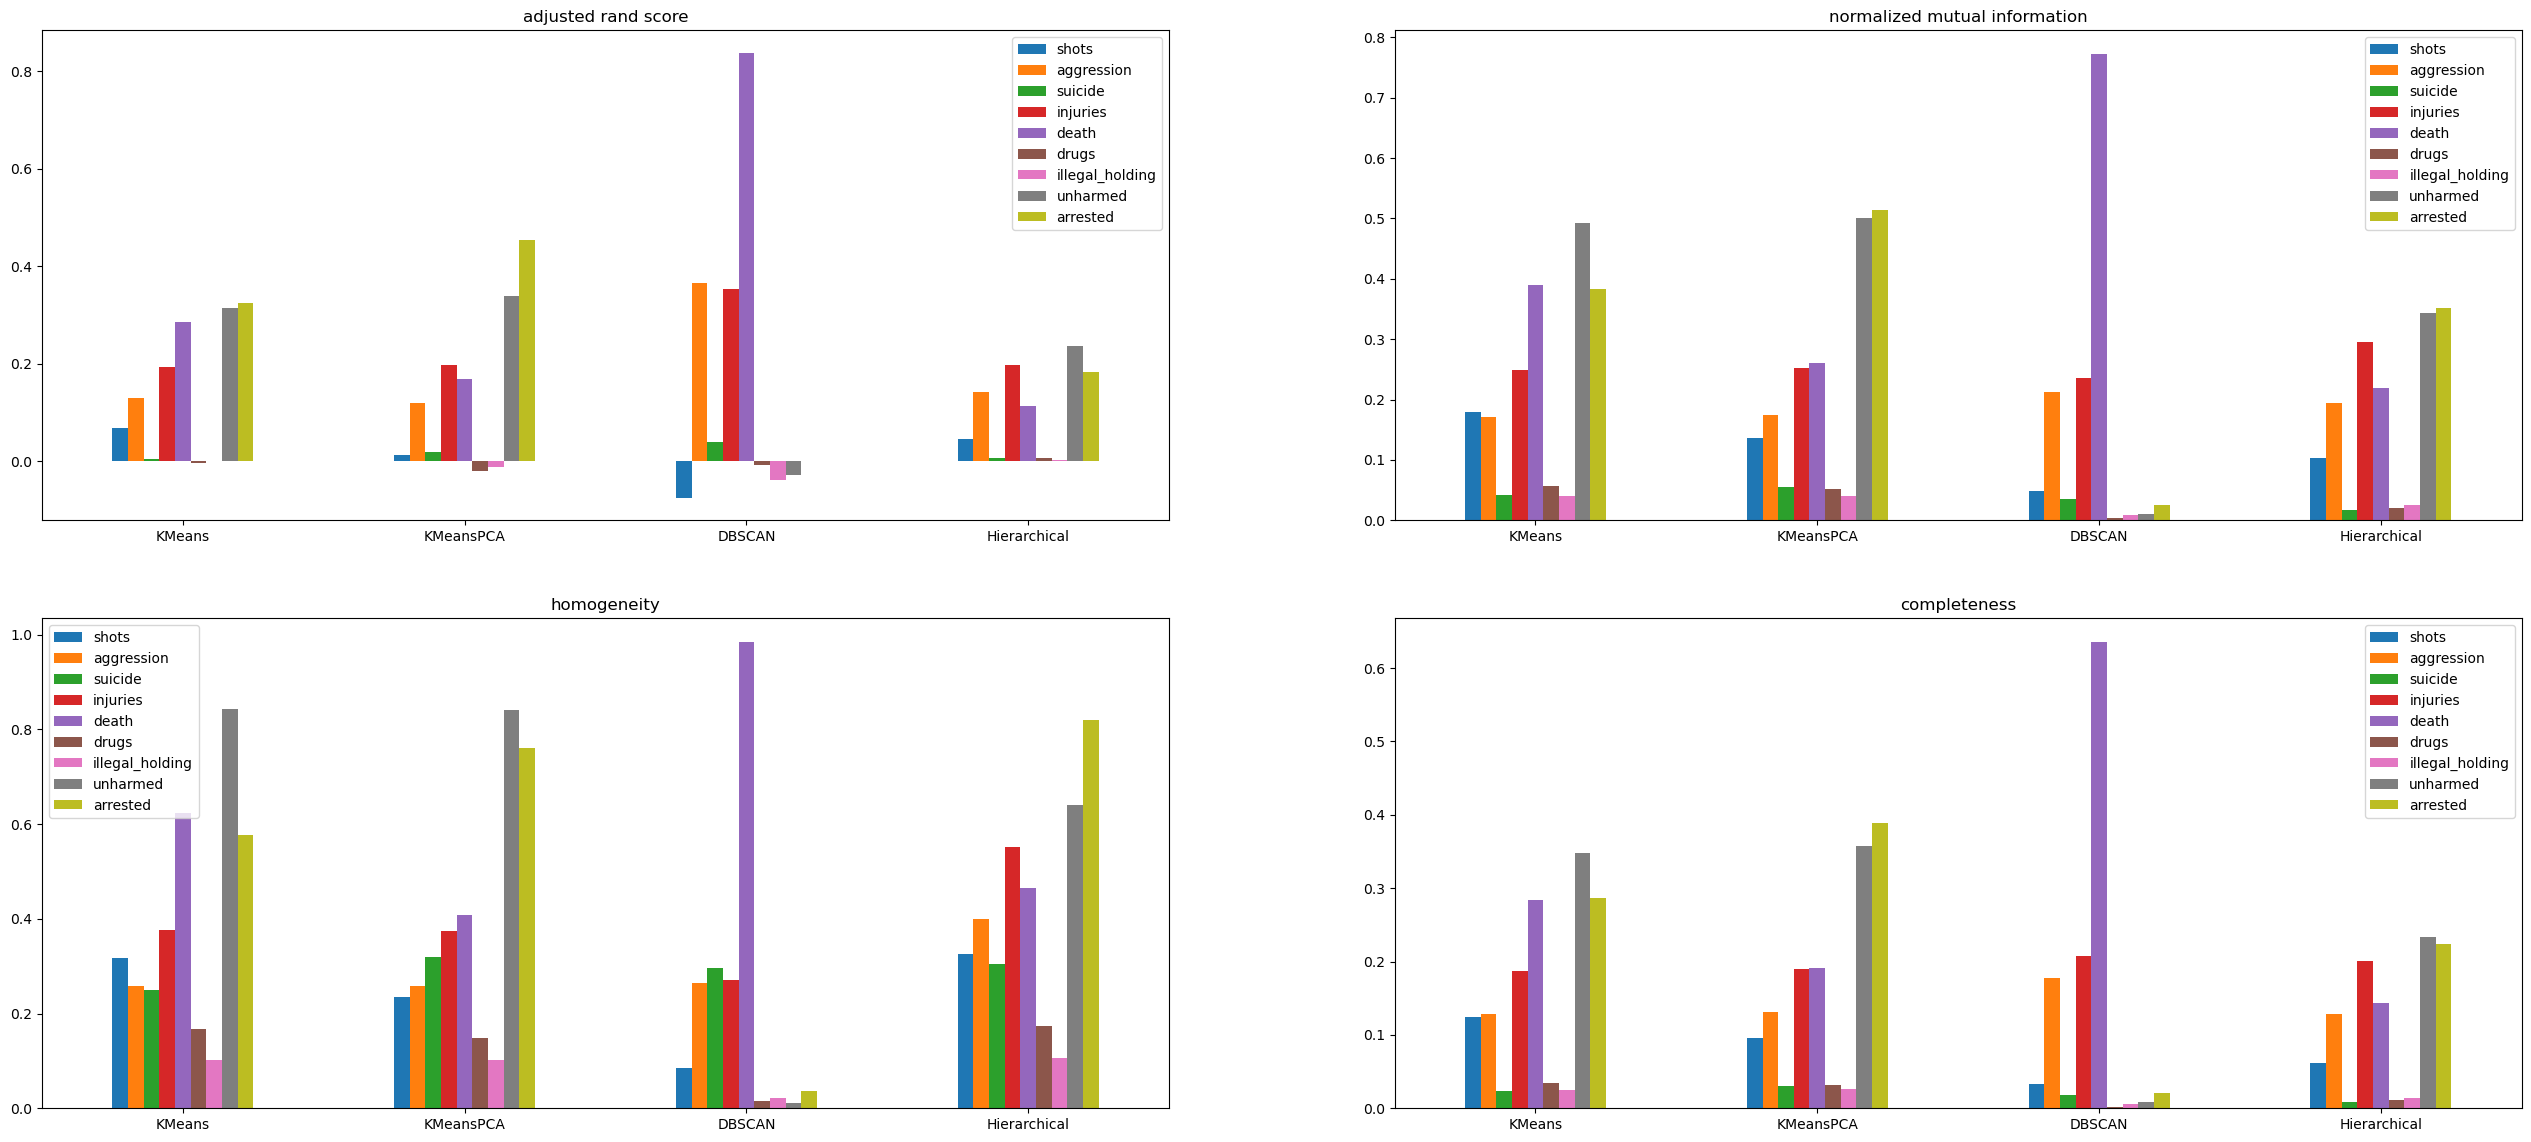

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(32, 14))
for i, key in enumerate(scores_per_metric):
    pd.DataFrame(np.array(scores_per_metric[key]), index=algs_order, columns=features_order).plot.bar(rot=0, title=key, ax=axs[int(i/2)][i%2])

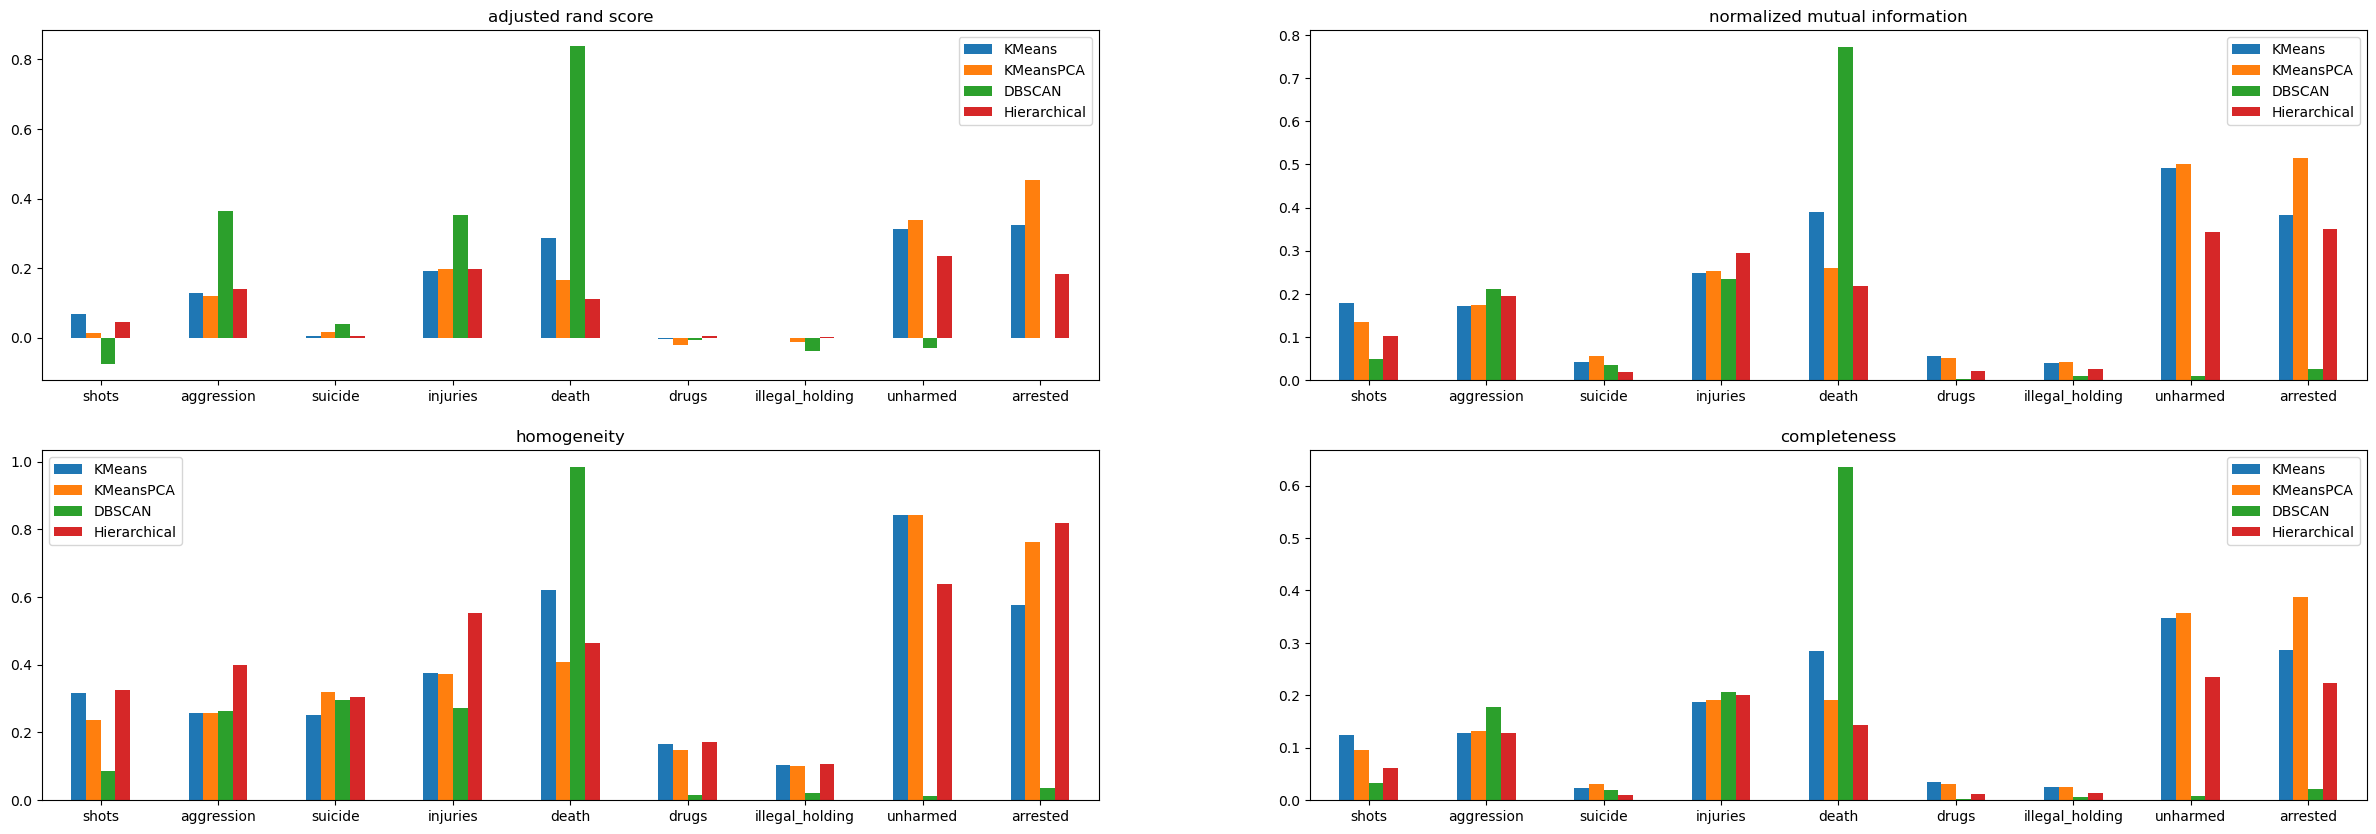

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(30, 10))
for i, key in enumerate(scores_per_metric):
    pd.DataFrame(np.array(scores_per_metric[key]).T, index=features_order, columns=algs_order).plot.bar(rot=0, title=key, ax=axs[int(i/2)][i%2])

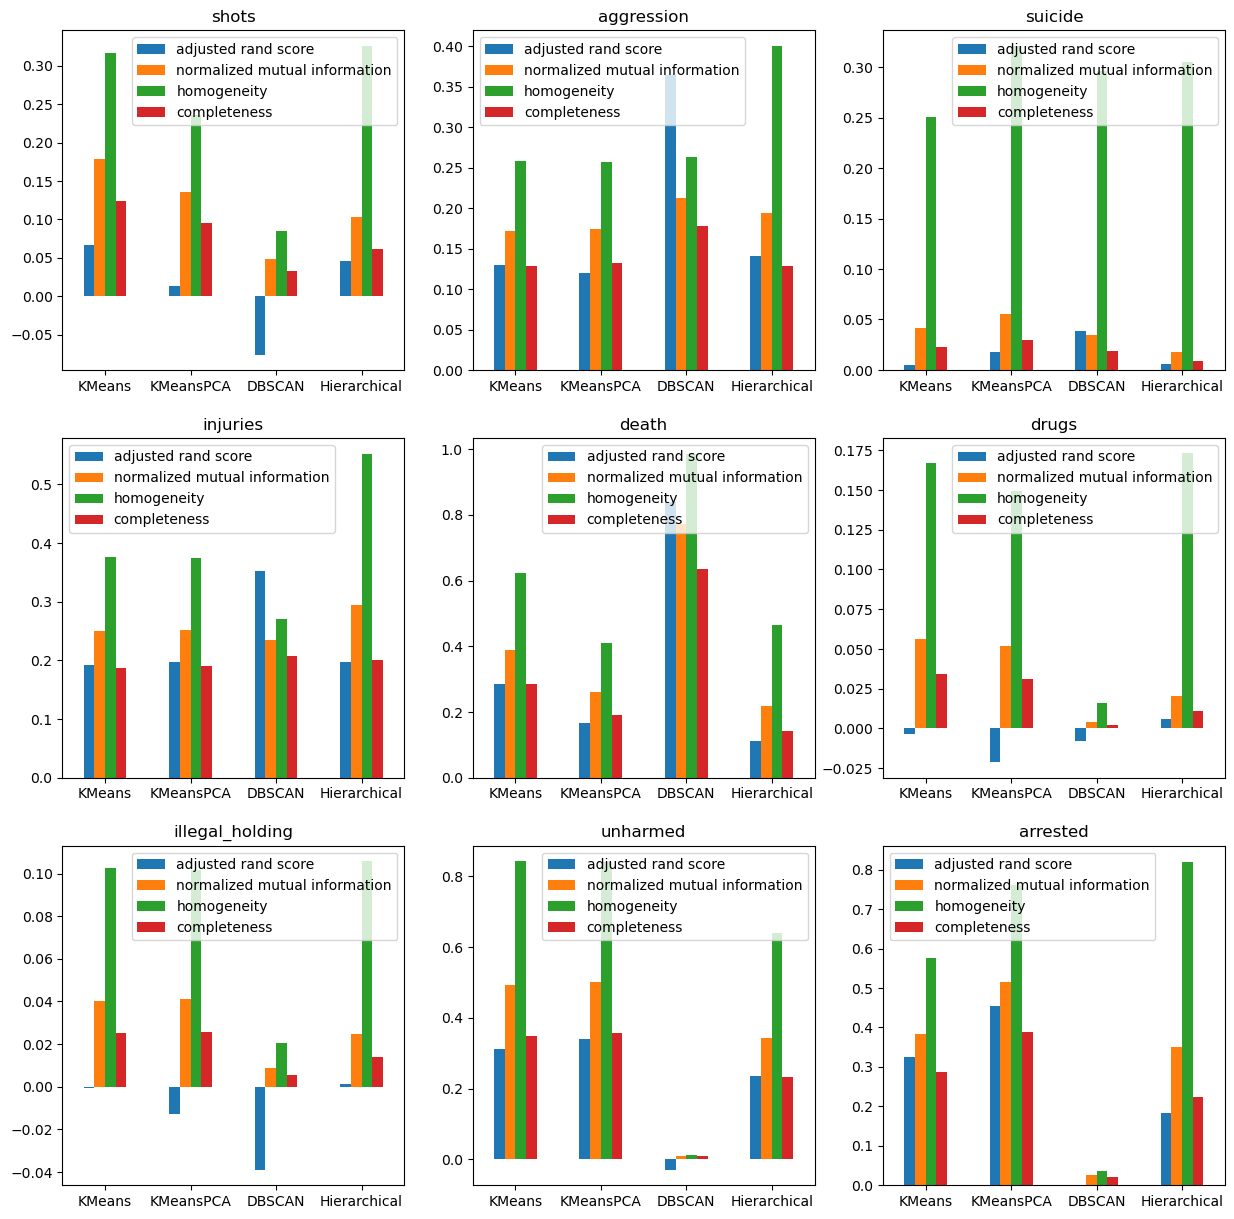

In [11]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
for i, key in enumerate(scores_per_feature):
    pd.DataFrame(np.array(scores_per_feature[key]), index=algs_order, columns=scores_order).plot.bar(rot=0, title=key, ax=axs[int(i/3)][i%3])

Regarding the external scores:
- the class 'death' is better clustered by DBSCAN
- KMeans has similar scores to KMeansPCA; KMeansPCA works better in identifying incidents from the class 'arrest'
- Heirarchical clustering has the highest scores for the class 'arrested' and works also better than the other algorithms in identifying incidents from the classes 'aggression' and 'injuries'